In [2]:
from __future__ import print_function
import mxnet as mx
from mxnet import nd, autograd, gluon
import seaborn as sn
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objs as go
import plotly.offline as py

C:\Users\think\Miniconda2\envs\py36\lib\site-packages\ipywidgets\widgets\widget.py:281: DeprecationWarning:

Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.



In [3]:
#set seed
mx.random.seed(1)
# context
data_ctx = mx.cpu()
model_ctx = mx.cpu()

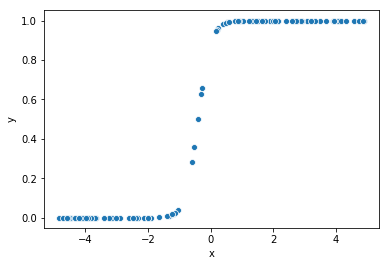

In [4]:
#1d regression
num_inputs = 1
num_outputs = 1
num_examples = 100

realw = 5
realb = 2
#sigmoid function
def sigmoid(input):
    return 1/(1+mx.nd.exp(-input))

#real function, using sigmoid function so that loss function becomes more complicated
def real_fn(X):
    return sigmoid(realw * X[:, 0] + realb)

#generate sample points
x_low = -5
x_hi = 5
X = nd.random_uniform(low=x_low,high=x_hi,shape=(num_examples, num_inputs), ctx=data_ctx)
y = real_fn(X)

df=pd.DataFrame(np.concatenate((X.asnumpy(),y.asnumpy().reshape(-1,1)),axis=1),columns=['x','y'])
df.head()

#plot data
sn.scatterplot(x="x", y="y", data=df)

In [8]:
batch_size = 1
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(X, y),
                                      batch_size=batch_size, shuffle=False)
w = nd.random_normal(shape=(num_inputs, num_outputs), ctx=model_ctx)
b = nd.random_normal(shape=num_outputs, ctx=model_ctx)
w = nd.array([[-1]])#starting of w
b = nd.array([0])#starting of b
params = [w, b]
for param in params:
    param.attach_grad()
    
def net(X):
    return sigmoid(mx.nd.dot(X, w) + b)


def square_loss(yhat, y):
    return nd.mean((yhat - y) ** 2)

def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad


epochs = 100
learning_rate = 10
num_batches = num_examples/batch_size

wbtra = []

for e in range(epochs):
    cumulative_loss = 0
    # inner loop
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx)
        #print(data.asnumpy())
        #print('--')
        label = label.as_in_context(model_ctx).reshape((-1, 1))
        with autograd.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        wbtra.append([params[0].asnumpy()[0,0],params[1].asnumpy()[0]])
        SGD(params, learning_rate)
        cumulative_loss += loss.asscalar()
    print('epoch:{},loss:{}'.format(e,cumulative_loss / num_batches))
dfwb = pd.DataFrame(wbtra,columns=['w','b'])

epoch:0,loss:0.012990028558290088
epoch:1,loss:7.020198341173128e-05
epoch:2,loss:4.383652498826368e-05
epoch:3,loss:2.838455728835507e-05
epoch:4,loss:1.8854209081025587e-05
epoch:5,loss:1.276335042264311e-05
epoch:6,loss:8.766113937162685e-06
epoch:7,loss:6.089007260699351e-06
epoch:8,loss:4.267296422332712e-06
epoch:9,loss:3.0120938424877773e-06
epoch:10,loss:2.1384715479319562e-06
epoch:11,loss:1.5254458211166474e-06
epoch:12,loss:1.0924224273304422e-06
epoch:13,loss:7.848594368774035e-07
epoch:14,loss:5.654093954331052e-07
epoch:15,loss:4.082483726930075e-07
epoch:16,loss:2.9531730819042354e-07
epoch:17,loss:2.1396807821484204e-07
epoch:18,loss:1.5524398381788803e-07
epoch:19,loss:1.1276349926001755e-07
epoch:20,loss:8.199121472983926e-08
epoch:21,loss:5.966047217639841e-08
epoch:22,loss:4.3438284401276644e-08
epoch:23,loss:3.165458030828824e-08
epoch:24,loss:2.3077138656669687e-08
epoch:25,loss:1.682985384756897e-08
epoch:26,loss:1.227828443671287e-08
epoch:27,loss:8.961361894229

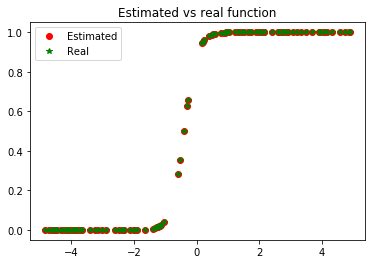

In [9]:
f, (fg1) = plt.subplots(1, 1)
fg1.set_title('Estimated vs real function')
fg1.plot(X.asnumpy(),
             net(X).asnumpy(), 'or', label='Estimated')
fg1.plot(X.asnumpy(),
             real_fn(X).asnumpy(), '*g', label='Real')
fg1.legend()

plt.show()

In [10]:
def plotwb(x,y,dfwb,realw,realb):
    w=np.mgrid[-5:10:.1,-5:10:.1][0,:,:].reshape(-1,1)
    b=np.mgrid[-5:10:.1,-5:10:.1][1,:,:].reshape(-1,1)
    temp = []
    for ww,bb in zip(w,b):
        l = np.mean((1/(1+np.exp(-ww*x-bb))-y)**2)
        temp.append(l)
    loss = np.array(temp).reshape(-1,1)
    
    data=pd.DataFrame(np.concatenate((w,b,loss),axis=1),columns=['x','y','l'])
    
    print('minimal loss:{}'.format(data.loc[data['l'].idxmin(),:]))

    # Create trace
    trace0 = go.Scatter(
        x = data['x'].values,
        y = data['y'].values,
        mode = 'markers',
        marker = dict(
            color = data['l'].values,
            colorscale='Viridis'
        )
    )
    trace1 = go.Scatter(
        x = dfwb['w'].values,
        y = dfwb['b'].values,
        mode = 'lines',
        line = dict(
            color = ('rgb(255, 0, 0)')
        )
    )
    trace2 = go.Scatter(
        x = [realw],
        y = [realb],
        mode = 'markers',
        marker = dict(
            color = ('rgb(255, 0, 0)')
        )
    )
    data = [trace0,trace1,trace2]
    py.plot(data)

plotwb(X.asnumpy().reshape(-1,1),y.asnumpy().reshape(-1,1),dfwb,realw,realb)

minimal loss:x    5.000000e+00
y    2.000000e+00
l    4.840824e-16
Name: 15070, dtype: float64


In [11]:
dfwb.tail()

,w,b
9995,4.999993,1.999998
9996,4.999993,1.999998
9997,4.999993,1.999998
9998,4.999993,1.999998
9999,4.999993,1.999998
